# Config & Import Libraries

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pip install calmap
#import calmap

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import datetime
import itertools
import pickle

# apartado ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Data Loading

In [2]:
# Leemos los ficheros
ruta = '../data/'
df_forecast = pd.read_csv(ruta+'daily_sales_cleandata.csv')

In [3]:
df_forecast.head()

,id,item,category,department,store,store_code,region,d,qty_sold,date,weekday_int,holiday,weekend,yearweek,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,12.7414
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.2801
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9501
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.7722
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9634


In [4]:
# Pasamos la variable 'date' a tipo fecha:
#df_forecast["date"] = pd.to_datetime(df_forecast["date"], format = "%Y-%m-%d")

In [5]:
# Generamos una nueva columna como 'week_day' para poder utilizarla como index:
df_forecast['year'] = df_forecast['yearweek'].astype(str).str[:4]
df_forecast['week'] = df_forecast['yearweek'].astype(str).str[4:] 
df_forecast['week_day'] = pd.to_datetime(df_forecast['year'] + df_forecast['week'] + '-1', format='%Y%U-%w')

In [6]:
#df_forecast.to_csv(ruta+'df_forecast.csv', index=False)

In [7]:
# Borramos aquellas variables que no suman al modelo:
df_forecast.drop(['d','date','weekend', 'weekday_int','yearweek'], inplace=True, axis=1)

In [8]:
df_forecast.groupby(['id'])['qty_sold'].sum().to_frame().sort_values(by='qty_sold', ascending=False)

,qty_sold
id,
SUPERMARKET_3_090_NYC_3,250502
SUPERMARKET_3_586_BOS_2,192835
SUPERMARKET_3_586_BOS_3,150122
SUPERMARKET_3_586_NYC_3,134386
SUPERMARKET_3_090_NYC_1,127203
...,...
SUPERMARKET_2_057_PHI_2,16
SUPERMARKET_2_071_BOS_3,16
ACCESORIES_1_170_PHI_3,13


In [9]:
'store','store_code','region'

('store', 'store_code', 'region')

In [10]:
# Importo el dataset de test:
df_test = pd.read_csv(ruta+'df_test.csv',delimiter=';')

In [11]:
# Transformo algunas columnas al mismo tipo de dato que el dataset de forecast:
df_test['year'] = df_test['year'].astype(str)
df_test['week'] = df_test['week'].astype(str)
df_test['week_day'] = pd.to_datetime(df_test['year'] + df_test['week'] + '-1', format='%Y%U-%w')

In [12]:
# Unimos los dos datasets:
df_forecast = pd.concat([df_forecast, df_test], ignore_index=True)

In [13]:
df_forecast.tail()

,id,item,category,department,store,store_code,region,qty_sold,holiday,sell_price,year,week,week_day
58449325,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,NaN,0,NaN,2016,20,2016-05-16
58449326,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,NaN,0,NaN,2016,20,2016-05-16
58449327,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,NaN,0,NaN,2016,20,2016-05-16
58449328,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,NaN,0,NaN,2016,20,2016-05-16
58449329,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,NaN,0,NaN,2016,20,2016-05-16


# Asignación de valores numericos a los nulos:

In [14]:
df_forecast.isnull().sum()

id                 0
item               0
category           0
department         0
store              0
store_code         0
region             0
qty_sold      121960
holiday            0
sell_price    121960
year               0
week               0
week_day           0
dtype: int64

In [15]:
# Asignamos valores a sell_price:
df_forecast['sell_price'] = df_forecast.groupby(['id'])['sell_price'].transform(lambda series: series.bfill().ffill())

In [16]:
# Reemplazamos los valores NaN de 'qty_sold' con cero, ya que son los valores a predecir:
df_forecast['qty_sold'].fillna(0, inplace=True)

# Data Transformation: creacion de diccionarios.

In [17]:
store_dict = {

    'South_End': 1,
    'Roxbury': 2,
    'Back_Bay': 3,
    'Greenwich_Village': 4,
    'Harlem' : 5,
    'Tribeca': 6, 
    'Brooklyn': 7,
    'Midtown_Village': 8,
    'Yorktown':9, 
    'Queen_Village': 10

}

df_forecast["store_encode"]=df_forecast["store"].map(store_dict)

In [18]:
department_dict = {

    'SUPERMARKET_3': 1,      
    'HOME_&_GARDEN_1' : 2,   
    'HOME_&_GARDEN_2' :3, 
    'ACCESORIES_1' :4,      
    'SUPERMARKET_2': 5,  
    'SUPERMARKET_1':6,       
    'ACCESORIES_2':7       

}

df_forecast["department_encode"]=df_forecast["department"].map(department_dict)

In [19]:
category_dict = {

    'SUPERMARKET': 1,
    'HOME_&_GARDEN': 2,
    'ACCESORIES': 3
   
}

df_forecast["category_encode"]=df_forecast["category"].map(category_dict)

In [20]:
region_dict ={

    'New York': 1,
    'Boston': 2,
    'Philadelphia':3

}

df_forecast["region_encode"]=df_forecast["region"].map(region_dict)

In [21]:
# Borramos las columnas encodeadas:
df_forecast.drop([
                    'category',
                    'department', 
                    'region', 
                    'store', 
                    'store_code',
                    'item'], 
                    axis=1, inplace=True)

In [22]:
df_forecast.head()

,id,qty_sold,holiday,sell_price,year,week,week_day,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,0.0,0,12.7414,2011,04,2011-01-24,4,4,3,1
1,ACCESORIES_1_002_NYC_1,0.0,0,5.2801,2011,04,2011-01-24,4,4,3,1
2,ACCESORIES_1_003_NYC_1,0.0,0,3.9501,2011,04,2011-01-24,4,4,3,1
3,ACCESORIES_1_004_NYC_1,0.0,0,5.7722,2011,04,2011-01-24,4,4,3,1
4,ACCESORIES_1_005_NYC_1,0.0,0,3.9634,2011,04,2011-01-24,4,4,3,1


In [23]:
# Renombramos 'week_day' como 'date':
df_forecast.rename(columns={'week_day': 'date'}, inplace=True)

# Visualizamos las ventas

In [24]:
df = df_forecast.copy()

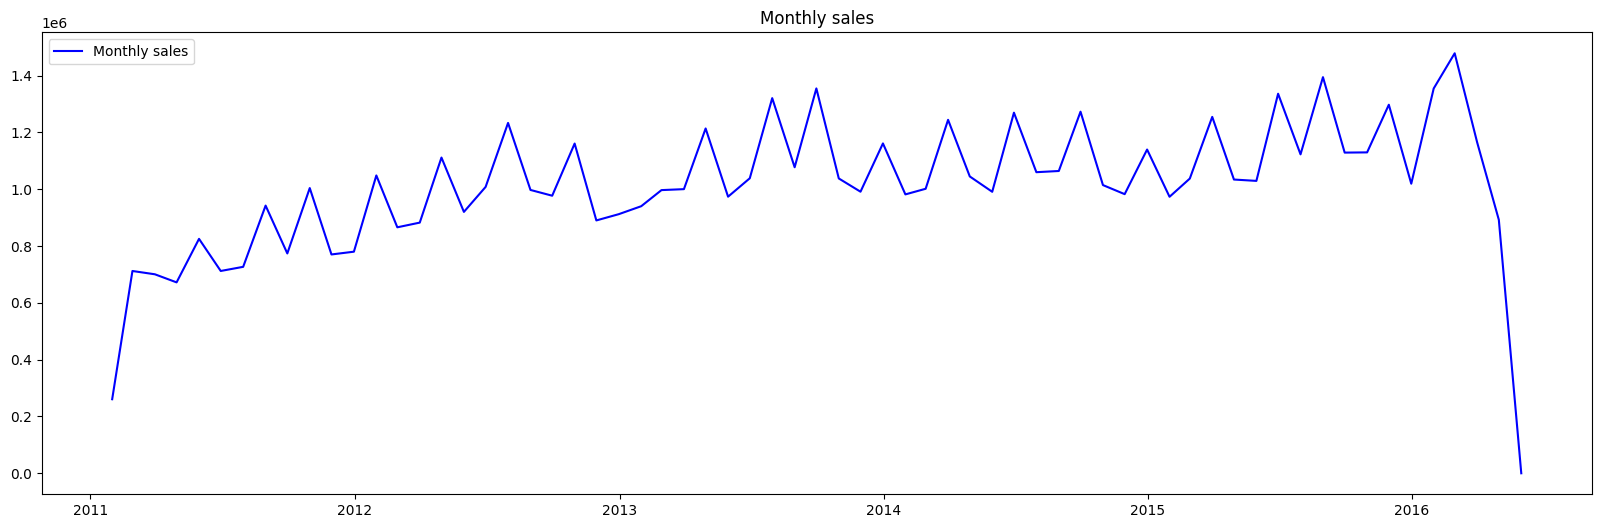

In [25]:
# Consultamos las ventas mensuales:
x= df[['date', "qty_sold"]].set_index('date').resample("M").sum()

# Vemos la evolución de las ventas mensuales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Monthly sales")
plt.legend()

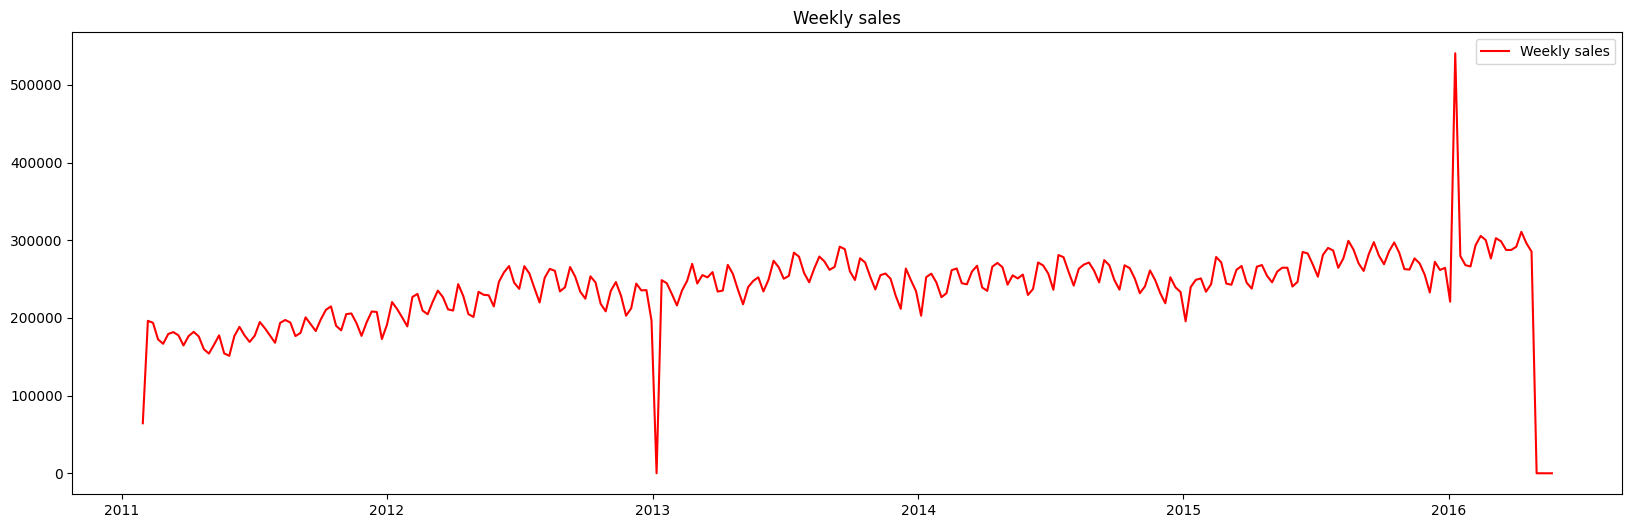

In [26]:
# Consultamos las ventas semanales:
x= df[['date', "qty_sold"]].set_index('date').resample("W").sum()

# Vemos la evolución de las ventas semanales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "red", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend()

### EDA: Global Sales

In [27]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

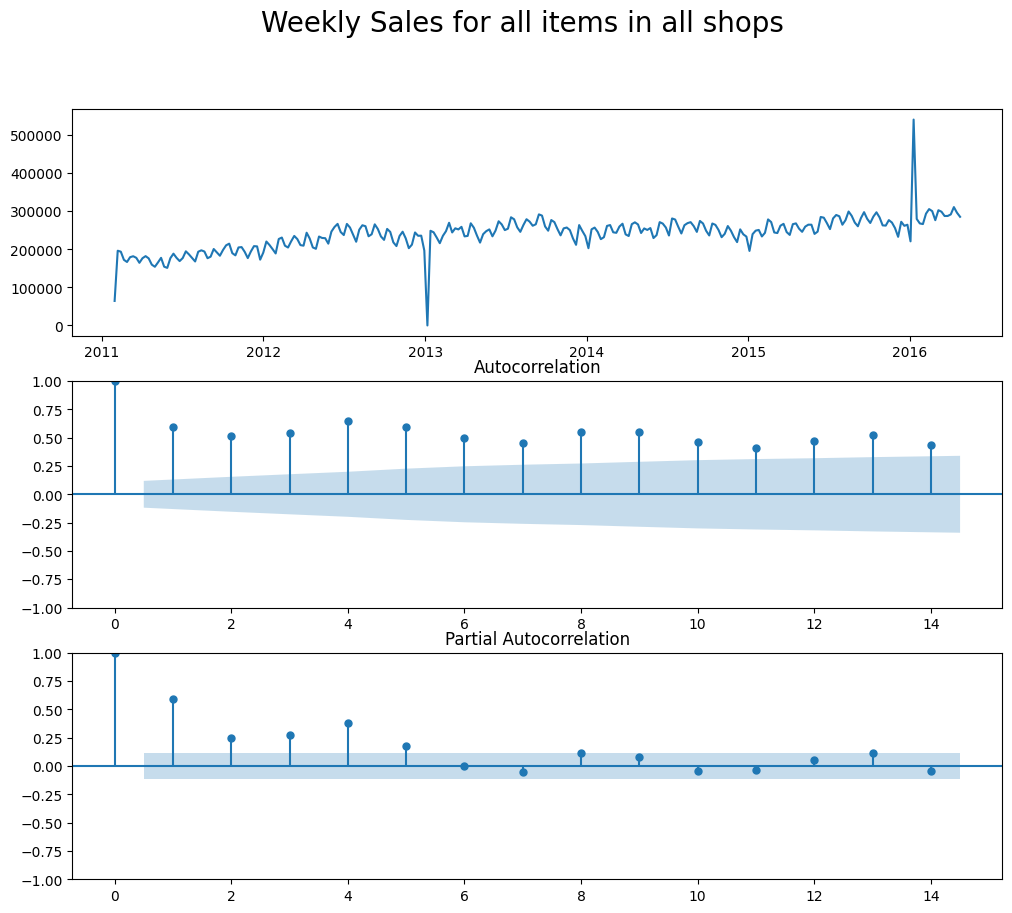

In [28]:
y = df.set_index("date").resample("W")["qty_sold"].sum()[:-4] # quitamos los registros de las ultimas cuatro semanas.
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops")

## · Building Time Series Features:

In [29]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_ma3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1).rolling(3).mean()
    )
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [30]:
df.head()

,id,qty_sold,holiday,sell_price,year,week,date,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,0.0,0,12.7414,2011,04,2011-01-24,4,4,3,1
1,ACCESORIES_1_002_NYC_1,0.0,0,5.2801,2011,04,2011-01-24,4,4,3,1
2,ACCESORIES_1_003_NYC_1,0.0,0,3.9501,2011,04,2011-01-24,4,4,3,1
3,ACCESORIES_1_004_NYC_1,0.0,0,5.7722,2011,04,2011-01-24,4,4,3,1
4,ACCESORIES_1_005_NYC_1,0.0,0,3.9634,2011,04,2011-01-24,4,4,3,1


In [31]:
'''GB_LIST = ['store_encode','id']          #,"item_id"
TARGET_COLUMN = "qty_sold"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_.head(10)

print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)'''

'GB_LIST = [\'store_encode\',\'id\']          #,"item_id"\nTARGET_COLUMN = "qty_sold"\nAGG_FUNC = np.sum\nAGG_FUNC_NAME = "sum"\n\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = GB_LIST,\n    target_column = TARGET_COLUMN,\n    agg_func = AGG_FUNC,\n    agg_func_name =  AGG_FUNC_NAME\n\n)\n\nvars_ts_.head(10)\n\nprint(df.shape)\ndf = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")\nprint(df.shape)'

In [32]:
'''GB_LIST = ['store_encode','id']          # ,"item_id"
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_.head(10)

print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)'''

'GB_LIST = [\'store_encode\',\'id\']          # ,"item_id"\nTARGET_COLUMN = "sell_price"\nAGG_FUNC = np.sum\nAGG_FUNC_NAME = "sum"\n\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = GB_LIST,\n    target_column = TARGET_COLUMN,\n    agg_func = AGG_FUNC,\n    agg_func_name =  AGG_FUNC_NAME\n\n)\n\nvars_ts_.head(10)\n\nprint(df.shape)\ndf = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")\nprint(df.shape)'

In [33]:
#df['sales_mean_rolling'] = df.groupby(['id']).resample('W')['qty_sold'].transform(lambda series: series.shift(1).rolling(window = 2).mean())

In [34]:
df.head(3)

,id,qty_sold,holiday,sell_price,year,week,date,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,0.0,0,12.7414,2011,04,2011-01-24,4,4,3,1
1,ACCESORIES_1_002_NYC_1,0.0,0,5.2801,2011,04,2011-01-24,4,4,3,1
2,ACCESORIES_1_003_NYC_1,0.0,0,3.9501,2011,04,2011-01-24,4,4,3,1


### Train Test Split

In [35]:
df.columns.tolist()

['id',
 'qty_sold',
 'holiday',
 'sell_price',
 'year',
 'week',
 'date',
 'store_encode',
 'department_encode',
 'category_encode',
 'region_encode']

In [36]:
COLUMNS_TO_DROP = ['year','week'
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [37]:
df.set_index("id", inplace = True)

In [38]:
df.sample(5)

,qty_sold,holiday,sell_price,date,store_encode,department_encode,category_encode,region_encode
id,,,,,,,,
SUPERMARKET_3_082_PHI_3,5.0,0,2.3760,2015-03-09,10,1,1,3
HOME_&_GARDEN_2_390_NYC_3,2.0,0,7.0875,2011-05-16,6,3,2,1
SUPERMARKET_3_045_PHI_1,0.0,0,4.7760,2016-01-04,8,1,1,3
HOME_&_GARDEN_1_501_NYC_1,0.0,0,4.9500,2015-11-02,4,2,2,1
SUPERMARKET_2_264_NYC_2,0.0,0,4.7640,2013-10-14,5,5,1,1


In [42]:
train_index = sorted(list(df["date"].unique()))[:-5]      #:-8

valida_index = [sorted(list(df["date"].unique()))[-5]]    # -8:-4

test_index = [sorted(list(df["date"].unique()))[-4]]    #-4:

In [43]:
print(f"Our train index is {train_index[:1]} - ... - {train_index[-1:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2011-01-24 00:00:00')] - ... - [Timestamp('2016-04-11 00:00:00')]

Our validation index is [Timestamp('2016-04-18 00:00:00')]

Our test/prediction index is [Timestamp('2016-04-25 00:00:00')]



In [44]:
X_train = df[df["date"].isin(train_index)].drop(['qty_sold', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['qty_sold']

X_valida = df[df["date"].isin(valida_index)].drop(['qty_sold', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['qty_sold']

X_test = df[df["date"].isin(test_index)].drop(['qty_sold', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['qty_sold']

In [45]:
X_train.head(3)

,holiday,sell_price,store_encode,department_encode,category_encode,region_encode
id,,,,,,
ACCESORIES_1_001_NYC_1,0,12.7414,4,4,3,1
ACCESORIES_1_002_NYC_1,0,5.2801,4,4,3,1
ACCESORIES_1_003_NYC_1,0,3.9501,4,4,3,1


In [46]:
Y_train.tail(3)

id
SUPERMARKET_3_825_PHI_3    0.0
SUPERMARKET_3_826_PHI_3    1.0
SUPERMARKET_3_827_PHI_3    0.0
Name: qty_sold, dtype: float64

In [47]:
X_valida.tail(3)

,holiday,sell_price,store_encode,department_encode,category_encode,region_encode
id,,,,,,
SUPERMARKET_3_823_PHI_3,0,3.576,10,1,1,3
SUPERMARKET_3_824_PHI_3,0,2.976,10,1,1,3
SUPERMARKET_3_825_PHI_3,0,4.776,10,1,1,3
SUPERMARKET_3_826_PHI_3,0,1.536,10,1,1,3
SUPERMARKET_3_827_PHI_3,0,1.200,10,1,1,3


In [48]:
X_test.head(3)

,holiday,sell_price,store_encode,department_encode,category_encode,region_encode
id,,,,,,
ACCESORIES_1_001_BOS_1,0,10.9858,1,4,3,2
ACCESORIES_1_001_BOS_2,0,10.9858,2,4,3,2
ACCESORIES_1_001_BOS_3,0,10.9858,3,4,3,2
ACCESORIES_1_001_NYC_1,0,11.1454,4,4,3,1
ACCESORIES_1_001_NYC_2,0,11.1454,5,4,3,1


# Hiper-parametrizacion

In [49]:
'''from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 75, 100, 150],
    'max_depth': [5, 6, 7],
    'gamma' : [0, 0.1, 0.2],
#    'reg_alpha' : [0, 0.1, 0.01],
#    'reg_lambda': [0.9, 1, 1.1],
    'learning_rate' : [0.1, 0.25, 0.3]
}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)

model = grid_search.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [50, 75, 100, 150],\n    'max_depth': [5, 6, 7],\n    'gamma' : [0, 0.1, 0.2],\n#    'reg_alpha' : [0, 0.1, 0.01],\n#    'reg_lambda': [0.9, 1, 1.1],\n    'learning_rate' : [0.1, 0.25, 0.3]\n}\n\ngrid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')\ngrid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)\n\nmodel = grid_search.best_estimator_"

In [50]:
'''print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", grid_search.best_estimator_)
print("\n The best RMSE:", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'''

'print("---- Results from Random Search -----" )\nprint("\n The best estimator across ALL searched params:", grid_search.best_estimator_)\nprint("\n The best RMSE:", grid_search.best_score_)\nprint("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'

# Model Train

In [51]:
model = xgb.XGBRegressor(
              eval_metric = "rmse",
              seed = 175
#              , n_estimators = 75
#              , max_depth = 6
#              , gamma = 0
#              , reg_alpha =0
#              , reg_lambda = 1
#              , learning_rate = 0.1
              )

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = 10)

[0]	validation_0-rmse:3.74636	validation_1-rmse:3.26283
[10]	validation_0-rmse:3.57965	validation_1-rmse:3.11972
[20]	validation_0-rmse:3.56874	validation_1-rmse:3.11508
[30]	validation_0-rmse:3.56291	validation_1-rmse:3.10882
[40]	validation_0-rmse:3.55888	validation_1-rmse:3.10536
[50]	validation_0-rmse:3.55487	validation_1-rmse:3.10395
[60]	validation_0-rmse:3.55279	validation_1-rmse:3.10391
[70]	validation_0-rmse:3.55067	validation_1-rmse:3.09711
[80]	validation_0-rmse:3.54848	validation_1-rmse:3.09311
[90]	validation_0-rmse:3.54748	validation_1-rmse:3.09277
[99]	validation_0-rmse:3.54655	validation_1-rmse:3.09141


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### >> Model Evaluation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

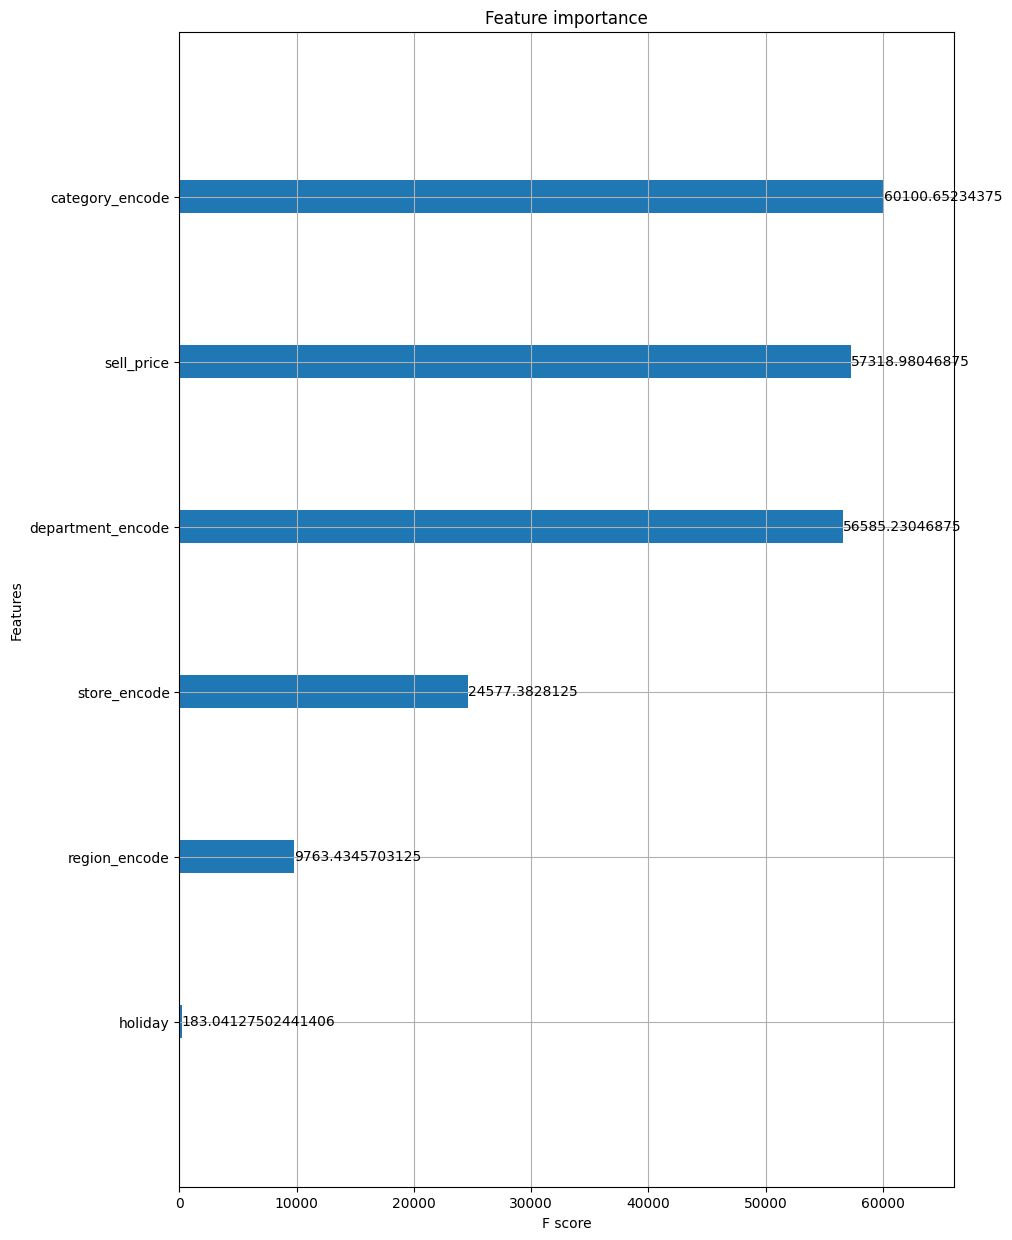

In [52]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax)

# Prediction

In [53]:
if "qty_sold" in X_test.columns:
    X_test.drop("qty_sold", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["qty_sold"] = Y_test_predict

In [54]:
X_test.reset_index(inplace = True)

In [55]:
X_test.head()

,id,holiday,sell_price,store_encode,department_encode,category_encode,region_encode,qty_sold
0,ACCESORIES_1_001_BOS_1,0,10.9858,1,4,3,2,0.357899
1,ACCESORIES_1_001_BOS_2,0,10.9858,2,4,3,2,0.507800
2,ACCESORIES_1_001_BOS_3,0,10.9858,3,4,3,2,0.463741
3,ACCESORIES_1_001_NYC_1,0,11.1454,4,4,3,1,0.669493
4,ACCESORIES_1_001_NYC_2,0,11.1454,5,4,3,1,0.562683


In [56]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [57]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_547
Validation RMSE: 3_091


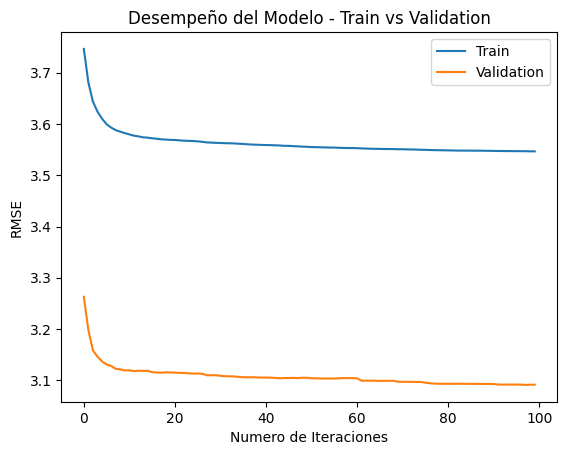

In [58]:
# Obtener métricas
results = model.evals_result()
# Gráfica de métricas
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# Métricas de entrenamiento
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
# Métricas de validação
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Numero de Iteraciones')
plt.ylabel('RMSE')
plt.title('Desempeño del Modelo - Train vs Validation')
plt.show()

In [59]:
# Subimos a Kaggle un fichero con este formato:
X_test[['date','id','qty_sold']]

,id,qty_sold
0,ACCESORIES_1_001_BOS_1,0.357899
1,ACCESORIES_1_001_BOS_2,0.507800
2,ACCESORIES_1_001_BOS_3,0.463741
3,ACCESORIES_1_001_NYC_1,0.669493
4,ACCESORIES_1_001_NYC_2,0.562683
...,...,...
30485,SUPERMARKET_3_827_NYC_3,7.273420
30486,SUPERMARKET_3_827_NYC_4,2.058007
30487,SUPERMARKET_3_827_PHI_1,2.623773
30488,SUPERMARKET_3_827_PHI_2,3.561929
